# Train model from values from MongoDB


### Download values from MongoDB
Steps:
1. Connect to MongoDB
2. Query the data
3. Convert the data to a DataFrame
4. Close the MongoDB connection

In [1]:
# Import necessary libraries
import yfinance as yf
from pymongo import MongoClient
from datetime import datetime
import matplotlib.pyplot as plt
import pymongo
import pandas as pd
import requests
from bson import ObjectId

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RNN, LSTMCell, LSTM
from tensorflow.keras.models import load_model, save_model
from tensorflow import function
from bson.binary import Binary
import pickle

In [2]:
# Declare Symbol to be used for testing
symbol = 'D05.SI'

In [3]:
# Connect to MongoDB
with open('../server/config.env', 'r') as file:
    connection_string = file.read().strip()

connection_string = connection_string.replace('ATLAS_URI=', '')

client = pymongo.MongoClient(connection_string)
db = client['bullsai']
collection = db['ticker_data']

In [4]:
# Query the data from MongoDB
dataTest = collection.find_one({"symbol": symbol})
# dataTest

#### Preprocessing

The downloaded data is in a format that is not suitable for analysis. It is converted to a time-series format and the column names are set appropriately.

In [5]:
# Convert the data to a DataFrame
dataDF = pd.DataFrame(dataTest['transactions'])

# Set Index to Date
dataDFTest = dataDF.set_index('Date')
dataDFTest.head()
# dataDFTest.info()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2000-01-03,11.488713,27.299999,27.500000,27.000000,27.400000,748000.0
2000-01-04,11.067874,26.299999,27.299999,26.000000,27.299999,2405000.0
2000-01-05,10.352468,24.600000,25.799999,24.600000,25.799999,3892000.0
2000-01-06,10.142050,24.100000,25.200001,23.400000,25.000000,2522000.0
2000-01-07,10.520802,25.000000,25.000000,23.799999,24.100000,3649000.0


In [6]:
# Check for null values
dataDFTest.isnull().sum()

Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

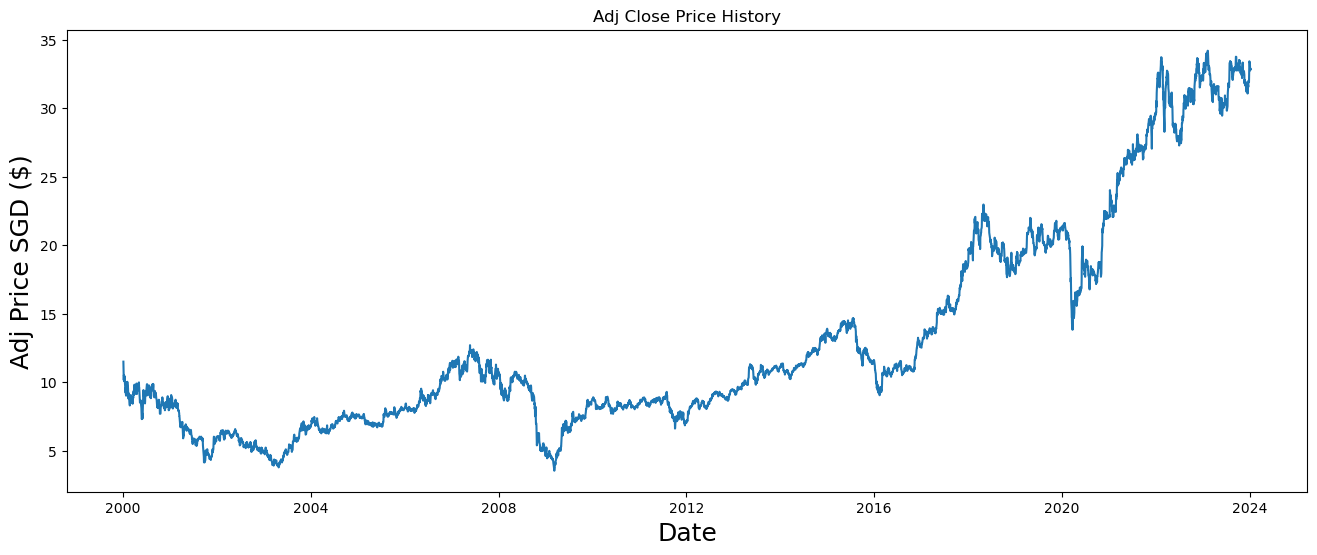

In [7]:
# Ensure your index is a DateTimeIndex
dataDFTest.index = pd.to_datetime(dataDFTest.index)

# # Resample to weekly frequency, taking the last price each week
# weekly_data = dataDFTest['Adj Close'].resample('W').last()

plt.figure(figsize=(16,6))
plt.title('Adj Close Price History')
plt.plot(dataDFTest['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Price SGD ($)', fontsize=18)
plt.show()

### Train model using LSTM

Steps: 
1) Split the data into training and test sets
2) Scale the data
3) Reshape the data into a 3D array
4) Build the LSTM model
5) Train the model
6) Evaluate the model

In [16]:
# Split the data into 80% training and 20% testing
train_size = int(len(dataDFTest) * 0.8)
test_size = len(dataDFTest) - train_size

# Visualize the training and testing data
train, test = dataDFTest.iloc[0:train_size], dataDFTest.iloc[train_size:len(dataDFTest)]
print(len(train), len(test))

4818 1205


In [17]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
print(train_scaled.shape)
print(test_scaled.shape)

(4818, 6)
(1205, 6)


In [18]:
# Create the training data set
x_train = []
y_train = []

for i in range(60, len(train_scaled)):
    x_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])

    if i <= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# print(x_train.shape)

[array([0.40974057, 0.38808274, 0.3512655 , 0.34043668, 0.35992854,
       0.34909943, 0.33610519, 0.35559689, 0.33610519, 0.33610519,
       0.31661353, 0.30795049, 0.294956  , 0.31011611, 0.29279047,
       0.28196161, 0.28845898, 0.30361889, 0.33177359, 0.31228213,
       0.31228213, 0.31444785, 0.33177359, 0.33393932, 0.32744229,
       0.31011611, 0.294956  , 0.27546434, 0.27113275, 0.29062441,
       0.28196161, 0.27979579, 0.28412738, 0.27113275, 0.25164119,
       0.24514402, 0.27763011, 0.26463568, 0.27763011, 0.27113275,
       0.27979579, 0.28412738, 0.26896702, 0.25813826, 0.25597259,
       0.26030418, 0.26246985, 0.2668014 , 0.27329847, 0.26246985,
       0.26463568, 0.25164119, 0.27763011, 0.27329847, 0.29279047,
       0.2992875 , 0.2992875 , 0.28412738, 0.31228213, 0.31444785])]
[0.32311069871389586]

[array([0.40974057, 0.38808274, 0.3512655 , 0.34043668, 0.35992854,
       0.34909943, 0.33610519, 0.35559689, 0.33610519, 0.33610519,
       0.31661353, 0.30795049, 0.29

In [19]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2024-01-16 18:11:06.338541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 18:11:06.571693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 18:11:06.627899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 18:11:06.730093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   4/4758 [..............................] - ETA: 1:39 - loss: 0.0666   

2024-01-16 18:11:06.875132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4758/4758 [==============================] - 90s 19ms/step - loss: 7.7294e-04


In [1]:
# # Create the testing data set
# # Create a new array containing scaled values from index 1543 to 2003 
# test_data = test_scaled[training_data_len - 60: , :]

# # Create the data sets x_test and y_test
# x_test = []
# y_test = data[training_data_len:, :]
# for i in range(60, len(test_data)):
#     x_test.append(test_data[i-60:i, 0])

# # Convert x_test to a numpy array so it can be used for testing the LSTM model
# x_test = np.array(x_test)

# # Reshape the data to 3 dimensions, as the LSTM model is expecting
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# # Use the trained model to make predictions
# predictions = model.predict(x_test)

# # Undo scaling
# predictions = scaler.inverse_transform(predictions)

In [ ]:
# # Make predictions on the test data
# predictions = model.predict(x_test)

# # If your data was scaled, you need to inverse the scaling to get the actual values
# predictions = scaler.inverse_transform(predictions)

#### Functions to call:

In [2]:
def connect_to_db():
    with open('../server/config.env', 'r') as file:
        connection_string = file.read().strip()

    connection_string = connection_string.replace('ATLAS_URI=', '')

    client = pymongo.MongoClient(connection_string)
    db = client['bullsai']
    return db

def download_data(symbol):
    db = connect_to_db()
    collection = db['ticker_data']
    data = collection.find_one({"symbol": symbol})

    # if data is not None and 'transactions' in data:
    #     df = pd.DataFrame(data['transactions'])
    #     df = df.set_index('Date')
    # else:
    #     print(f"No data found for symbol {symbol}")
    #     df = pd.DataFrame()

    if data is not None and 'transactions' in data:
        # Convert the data to a DataFrame
        dataDF = pd.DataFrame(data['transactions'])
        dataDF = dataDF.set_index('Date')

    return dataDF

def create_dataset(data):
    data = data.filter(['Adj Close'])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    return dataset, training_data_len

def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.fit_transform(dataset), scaler

def create_training_data(scaled_data, training_data_len):
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    return np.array(x_train), np.array(y_train)

def reshape_data(x_train):
    return np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

def build_and_train_model(x_train, y_train):
    model = Sequential()
    # model.add(RNN(LSTMCell(128), return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # model.add(RNN(LSTMCell(64), return_sequences=False))
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=2)
    return model

def create_test_data(scaled_data, dataset, training_data_len):
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    return np.array(x_test), y_test

def make_predictions(model, x_test, scaler):
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    predictions = model.predict(x_test)
    return scaler.inverse_transform(predictions)

def calculate_rmse(predictions, y_test):
    return np.sqrt(np.mean(((predictions - y_test) ** 2)))

def plot_data(data, training_data_len, predictions, symbol):
    train = data[:training_data_len]
    valid = data[training_data_len:].copy()
    valid.loc[:, 'Predictions'] = predictions
    plt.figure(figsize=(16,6))
    plt.title(symbol + ' Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Adj Close Price SGD ($)', fontsize=18)
    plt.plot(train['Adj Close'])
    plt.plot(valid[['Adj Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

def save_model(model, model_path):
    model.save(model_path)

def load_model_if_exists(model_path):
    if os.path.exists(model_path):
        return load_model(model_path)
    else:
        return None
    
def load_model_from_db(symbol):
    # Connect to MongoDB
    db = connect_to_db()
    collection = db['models']
    doc = collection.find_one({'symbol': symbol})

    if doc is not None:
        print(f"Document found for symbol {symbol}")
        if 'model' in doc:
            print("Model key found in document")
            binary_model = doc['model']
            # Write the binary model to a file
            with open('model.h5', 'wb') as f:
                f.write(binary_model)
            # Load the model from the file
            model = load_model('model.h5')
            # Delete the temporary file
            os.remove('model.h5')
        else:
            print("Model key not found in document")
            model = None
    else:
        print(f"No document found for symbol {symbol}")
        model = None

    return model

def save_model_to_db(model, symbol):
    # Save the model to a file
    model.save('model.h5')

    # Read the model file and convert it to binary
    with open('model.h5', 'rb') as f:
        binary_model = Binary(f.read())

    # Connect to MongoDB
    db = connect_to_db()
    collection = db['models']

    # Store the binary model in MongoDB
    collection.update_one({'symbol': symbol}, {'$set': {'model': binary_model}}, upsert=True)

    # Delete the temporary file
    os.remove('model.h5')

In [21]:
symbol = "U11.SI"
data = download_data(symbol)
data.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2000-01-03,7.270509,15.4,15.4,15.1,15.2,751000.0
2000-01-04,7.223296,15.3,15.4,15.0,15.2,1037000.0
2000-01-05,6.798400,14.4,14.8,14.3,14.8,1051000.0
2000-01-06,6.562343,13.9,14.6,13.6,14.4,2781000.0
2000-01-07,6.798400,14.4,14.5,14.0,14.1,1458000.0


In [22]:
# load the model from mongodb
model = load_model_from_db(symbol)

Document found for symbol U11.SI
Model key found in document


Document found for symbol C6L.SI
Model key found in document
Model found for symbol C6L.SI. Using existing model.


2024-01-18 21:43:46.035691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 21:43:46.121672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 21:43:46.176254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 10ms/step


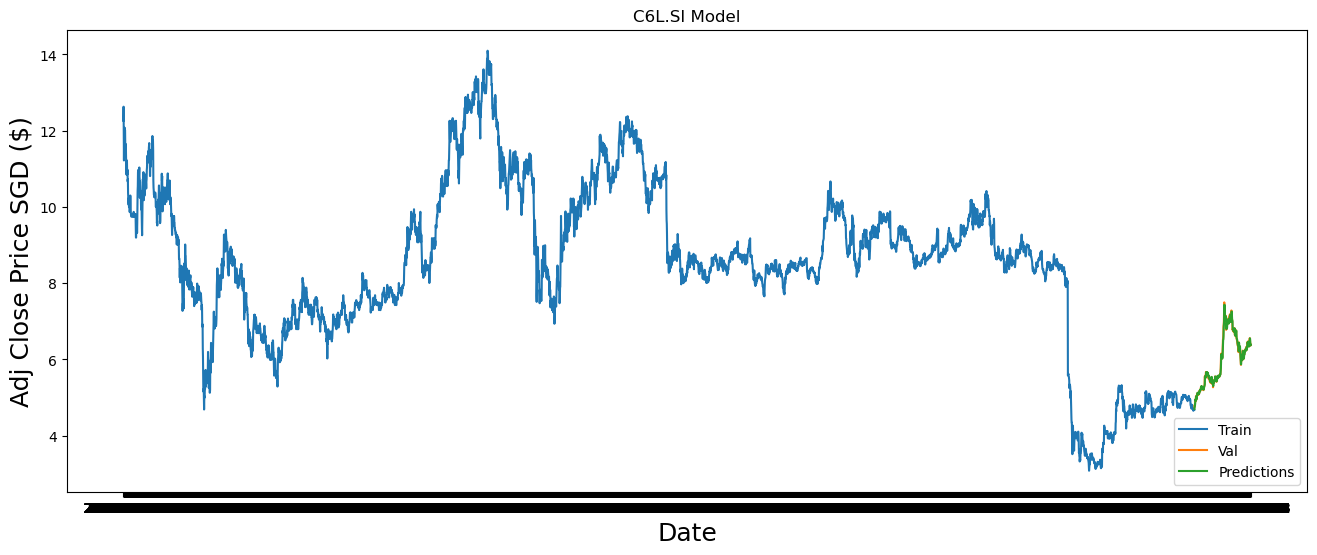

In [4]:
def main():
    symbol = "C6L.SI"
    # model_path = f"models/{symbol}_model.h5"
    
    # Use the new download_data function
    data = download_data(symbol)
    dataset, training_data_len = create_dataset(data)
    scaled_data, scaler = scale_data(dataset)
    
    # Use the new load_model_from_db function
    model = load_model_from_db(symbol)

    if model is None:
        print(f"No model found for symbol {symbol}. Please train a model first.")

        # Create the training data
        x_train, y_train = create_training_data(scaled_data, training_data_len)
        x_train = reshape_data(x_train)

        # Build and train the model
        model = build_and_train_model(x_train, y_train)

        # Save the model to MongoDB
        save_model_to_db(model, symbol)
    else:
        print(f"Model found for symbol {symbol}. Using existing model.")
        # return

    x_test, y_test = create_test_data(scaled_data, dataset, training_data_len)
    predictions = make_predictions(model, x_test, scaler)
    plot_data(data, training_data_len, predictions, symbol)

if __name__ == "__main__":
    main()